# Network Chosen: Zachary Karate Club

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (8, 6)


EDGE_FILE = "out.ucidata-zachary"   # keep the file in the same folder as the notebook


G = nx.read_edgelist(
    EDGE_FILE,
    comments="%",           # ignore lines starting with '%'
    nodetype=int,
    create_using=nx.Graph()
)

# Basic sanity checks
n = G.number_of_nodes()
m = G.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")
print("Connected? ->", nx.is_connected(G))


Nodes: 34, Edges: 78
Connected? -> True


# Q1a

In [68]:
def normalize_to_01(d):
    """Scale values of a {key: value} dict to [0,1] by max-min.
       If all values equal, return zeros."""
    if not d:
        return d
    vals = np.array(list(d.values()), dtype=float)
    vmin, vmax = float(np.min(vals)), float(np.max(vals))
    if np.isclose(vmin, vmax):
        return {k: 0.0 for k in d}
    return {k: (float(v) - vmin) / (vmax - vmin) for k, v in d.items()}

def degree_strength(G):
    """Vertex strength for unweighted graphs = degree; returns raw + normalized by (n-1)."""
    n = G.number_of_nodes()
    raw = dict(G.degree())
    norm = {u: (deg/(n-1) if n > 1 else 0.0) for u, deg in raw.items()}
    return raw, norm

def edge_strength(G, weight_attr="weight"):
    """Edge strength: if weighted use 'weight', else 1 for all edges."""
    if nx.get_edge_attributes(G, weight_attr):
        es = {e: G.edges[e].get(weight_attr, 1.0) for e in G.edges()}
    else:
        es = {e: 1.0 for e in G.edges()}
    return es, normalize_to_01(es)

def draw_nodes_by_value(G, values_dict, title, pos=None):
    """Draw nodes colored by a scalar dict (values_dict)."""
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    vals = np.array([values_dict.get(u, 0.0) for u in G.nodes()], dtype=float)
    vmin, vmax = float(vals.min()), float(vals.max()) if len(vals)>0 else (0.0, 1.0)

    plt.figure()
    nodes = nx.draw_networkx_nodes(G, pos, node_size=500, node_color=vals, cmap="viridis",
                                   vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=9)
    cbar = plt.colorbar(nodes, shrink=0.8)
    cbar.set_label("Normalized value")
    plt.title(title)
    plt.axis("off")
    plt.show()

def draw_edges_by_value(G, edge_dict, title, pos=None):
    """Draw edges with width mapped to edge_dict values; also color nodes uniformly."""
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    widths = [1.0 + 6.0*edge_dict.get(tuple(sorted(e)), 0.0) for e in G.edges()]
    plt.figure()
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color="#CFE8FF")
    nx.draw_networkx_edges(G, pos, width=widths, edge_color="#666666")
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title + " (edge width ∝ value)")
    plt.axis("off")
    plt.show()


## Edge Betweenness Centrality ($C_e^B$)
* **Edge Betweenness Centrality ($C_e^B$)**
    measures how often an edge lies on the shortest paths between pairs of vertices, indicating its importance as a communication link.
    $$C_e^B(q) = \frac{2}{V(V-1)} \sum_{x \neq y} \frac{m_{xy}(q)}{M_{xy}}$$
    where $m_{xy}(q)$ is the number of shortest paths between vertices x and y that pass through edge q.

In [69]:
# Edge betweenness centrality (normalized)
edge_bet = nx.edge_betweenness_centrality(G, normalized=True)
edge_bet_n = normalize_to_01(edge_bet)  # redundant but keeps outputs comparable

edge_bet_df = (pd.DataFrame([
    {"edge": tuple(sorted(e)), "edge_betweenness": edge_bet[e], "edge_betweenness_01": edge_bet_n[e]}
    for e in edge_bet
]).sort_values("edge_betweenness", ascending=False).reset_index(drop=True))

edge_bet_df.head(10)


,edge,edge_betweenness,edge_betweenness_01
0,"(1, 32)",0.127260,1.000000
1,"(1, 7)",0.078134,0.604746
2,"(1, 6)",0.078134,0.604746
3,"(1, 3)",0.077788,0.601958
4,"(1, 9)",0.074240,0.573411
5,"(3, 33)",0.068987,0.531148
6,"(14, 34)",0.067824,0.521792
7,"(20, 34)",0.059382,0.453873
8,"(1, 12)",0.058824,0.449377
9,"(27, 34)",0.054291,0.412908


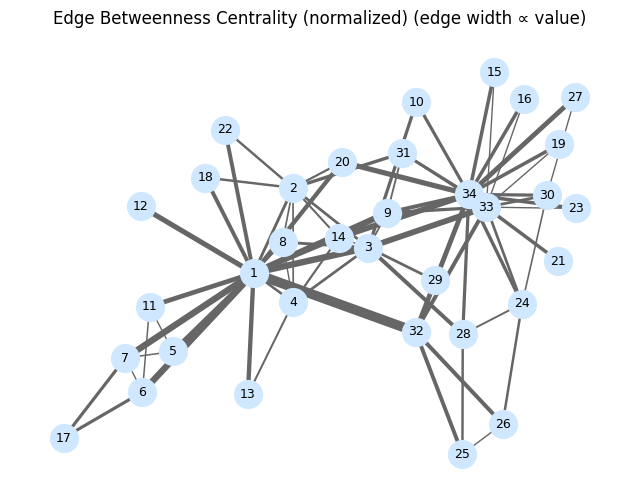

In [70]:
pos_main = nx.spring_layout(G, seed=7)
draw_edges_by_value(G, edge_bet_n, "Edge Betweenness Centrality (normalized)", pos=pos_main)


## Edge Strength ($w$)
* **Edge Strength ($w$)**
    measures the weight of an edge, which represents the strength of the connection.
    $$w(q)$$

In [71]:
e_strength_raw, e_strength_01 = edge_strength(G)

edge_strength_df = (pd.DataFrame([
    {"edge": tuple(sorted(e)), "edge_strength": e_strength_raw[e], "edge_strength_01": e_strength_01[e]}
    for e in e_strength_raw
]).sort_values("edge_strength", ascending=False).reset_index(drop=True))

edge_strength_df.head(10)



,edge,edge_strength,edge_strength_01
0,"(1, 2)",1.0,0.0
1,"(1, 3)",1.0,0.0
2,"(1, 4)",1.0,0.0
3,"(1, 5)",1.0,0.0
4,"(1, 6)",1.0,0.0
5,"(1, 7)",1.0,0.0
6,"(1, 8)",1.0,0.0
7,"(1, 9)",1.0,0.0
8,"(1, 11)",1.0,0.0
9,"(1, 12)",1.0,0.0


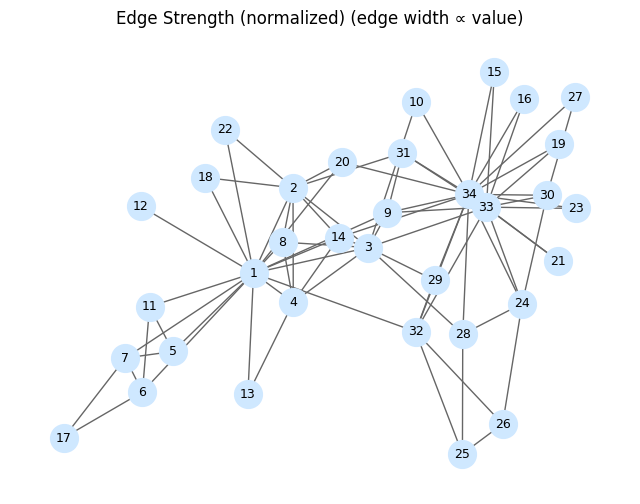

In [72]:
draw_edges_by_value(G, e_strength_01, "Edge Strength (normalized)", pos=pos_main)


## Vertex Betweenness Centrality ($C_v^B$)
* **Vertex Betweenness Centrality ($C_v^B$)**
    measures how often a vertex lies on the shortest paths between other pairs of vertices. A high value indicates a "bridge" role.
    $$C_v^B(q) = \frac{2}{(V-1)(V-2)} \sum_{x \neq y} \frac{m_{xy}(q)}{M_{xy}}$$
    where $m_{xy}(q)$ is the number of shortest paths between vertices x and y that pass through vertex q, and $M_{xy}$ is the total number of shortest paths between x and y.

In [73]:
node_bet = nx.betweenness_centrality(G, normalized=True)
node_bet_01 = normalize_to_01(node_bet)  # usually not needed, but we keep the same reporting style

bet_df = (pd.DataFrame({
    "node": list(node_bet.keys()),
    "betweenness": list(node_bet.values()),
    "betweenness_01": [node_bet_01[u] for u in node_bet]
}).sort_values("betweenness", ascending=False).reset_index(drop=True))

bet_df.head(10)




,node,betweenness,betweenness_01
0,1,0.437635,1.000000
1,34,0.304075,0.694814
2,33,0.145247,0.331891
3,3,0.143657,0.328257
4,32,0.138276,0.315961
5,9,0.055927,0.127793
6,2,0.053937,0.123246
7,14,0.045863,0.104798
8,20,0.032475,0.074206
9,6,0.029987,0.068521


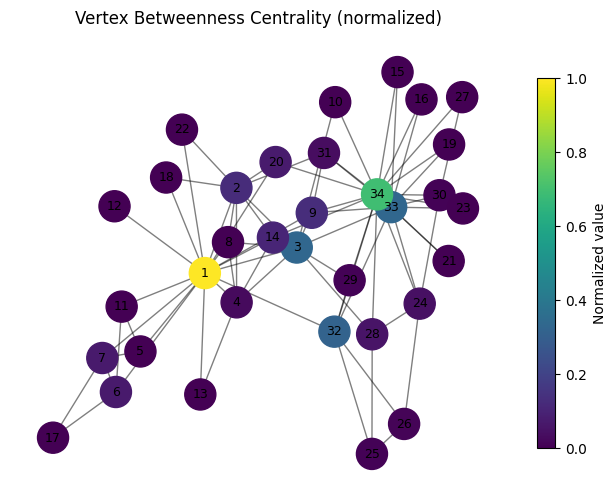

In [74]:
draw_nodes_by_value(G, node_bet_01, "Vertex Betweenness Centrality (normalized)", pos=pos_main)


## Vertex Closeness Centrality ($C_v^C$)
* **Vertex Closeness Centrality ($C_v^C$)**
    is a measure of how close a vertex is to all other vertices in the network, based on the sum of shortest path distances.
    $$C_v^C(q) = \frac{V-1}{\sum_x m_{qx}}$$
    where the denominator is the sum of shortest path distances from vertex `q` to all other vertices `x`.

In [75]:
node_clo = nx.closeness_centrality(G, wf_improved=True)
node_clo_01 = normalize_to_01(node_clo)

clo_df = (pd.DataFrame({
    "node": list(node_clo.keys()),
    "closeness": list(node_clo.values()),
    "closeness_01": [node_clo_01[u] for u in node_clo]
}).sort_values("closeness", ascending=False).reset_index(drop=True))

clo_df.head(10)


,node,closeness,closeness_01
0,1,0.568966,1.000000
1,3,0.559322,0.966102
2,34,0.550000,0.933333
3,32,0.540984,0.901639
4,14,0.515625,0.812500
5,9,0.515625,0.812500
6,33,0.515625,0.812500
7,20,0.500000,0.757576
8,2,0.485294,0.705882
9,4,0.464789,0.633803


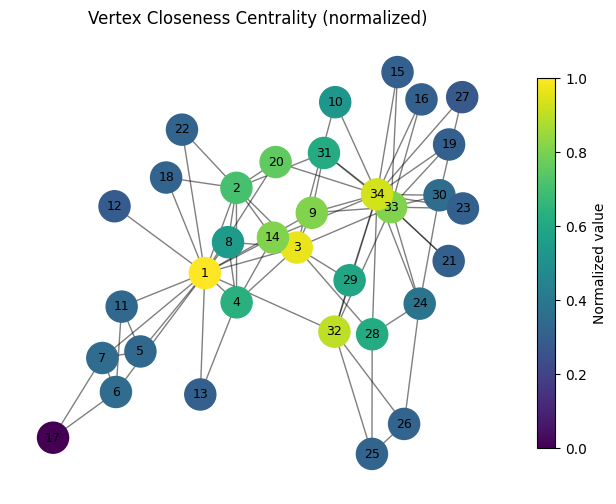

In [76]:
draw_nodes_by_value(G, node_clo_01, "Vertex Closeness Centrality (normalized)", pos=pos_main)


## Vertex Strength ($C_v^S$)
* **Vertex Strength ($C_v^S$)**
    is the sum of the weights of all edges connected to a vertex. It's a measure of a node's total direct influence in a weighted network.
    $$C_v^S(q) = \sum_x w_{qx}$$

In [77]:
v_strength_raw, v_strength_01 = degree_strength(G)

strength_df = (pd.DataFrame({
    "node": list(v_strength_raw.keys()),
    "strength_degree": list(v_strength_raw.values()),
    "strength_degree_01": [v_strength_01[u] for u in v_strength_raw]
}).sort_values("strength_degree", ascending=False).reset_index(drop=True))

strength_df.head(10)


,node,strength_degree,strength_degree_01
0,34,17,0.515152
1,1,16,0.484848
2,33,12,0.363636
3,3,10,0.303030
4,2,9,0.272727
5,4,6,0.181818
6,32,6,0.181818
7,24,5,0.151515
8,9,5,0.151515
9,14,5,0.151515


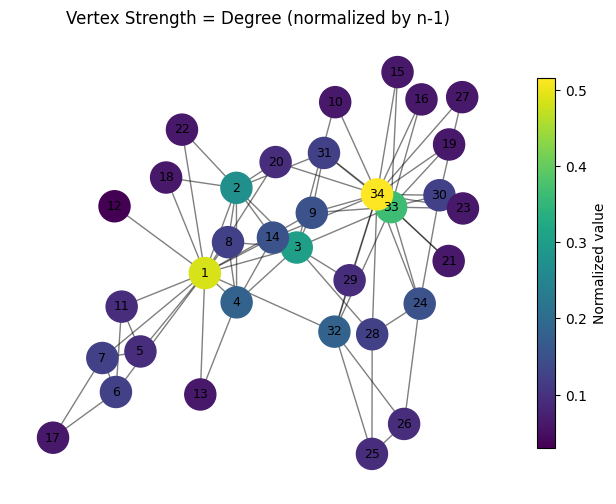

In [78]:
draw_nodes_by_value(G, v_strength_01, "Vertex Strength = Degree (normalized by n-1)", pos=pos_main)


## Vertex Eigenvector Centrality ($C_v^E$)
* **Vertex Eigenvector Centrality ($C_v^E$)**
    is a measure of a vertex's influence based on the idea that connections to other highly influential vertices contribute more. It's defined as the vertex's corresponding entry in the dominant eigenvector ($\vec{v}$) of the network's weighted adjacency matrix ($M^{(v)}$).
    $$M^{(v)}\vec{v} = \lambda_{max}\vec{v}$$

In [79]:
eig = nx.eigenvector_centrality(G, max_iter=2000)   # unit-norm vector internally
eig_01 = normalize_to_01(eig)

eig_df = (pd.DataFrame({
    "node": list(eig.keys()),
    "eigenvector": list(eig.values()),
    "eigenvector_01": [eig_01[u] for u in eig]
}).sort_values("eigenvector", ascending=False).reset_index(drop=True))

eig_df.head(10)


,node,eigenvector,eigenvector_01
0,34,0.373371,1.000000
1,1,0.355483,0.948854
2,3,0.317189,0.839360
3,33,0.308651,0.814946
4,2,0.265954,0.692862
5,9,0.227405,0.582640
6,14,0.226470,0.579965
7,4,0.211174,0.536230
8,32,0.191036,0.478650
9,31,0.174760,0.432113


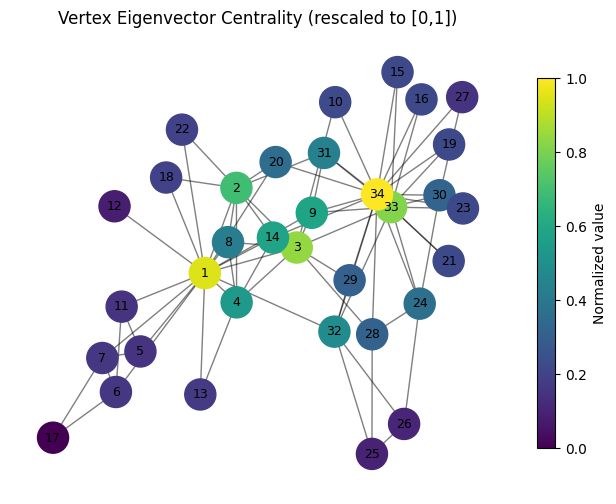

In [80]:
draw_nodes_by_value(G, eig_01, "Vertex Eigenvector Centrality (rescaled to [0,1])", pos=pos_main)


,node,betweenness,closeness_wf,degree,strength_norm,eigenvector_01
0,1,0.437635,0.568966,16,0.484848,0.948854
1,2,0.053937,0.485294,9,0.272727,0.692862
2,3,0.143657,0.559322,10,0.303030,0.839360
3,4,0.011909,0.464789,6,0.181818,0.536230
4,5,0.000631,0.379310,3,0.090909,0.149632
5,6,0.029987,0.383721,4,0.121212,0.159680
6,7,0.029987,0.383721,4,0.121212,0.159680
7,8,0.000000,0.440000,4,0.121212,0.421232
8,9,0.055927,0.515625,5,0.151515,0.582640
9,10,0.000848,0.434211,2,0.060606,0.226000


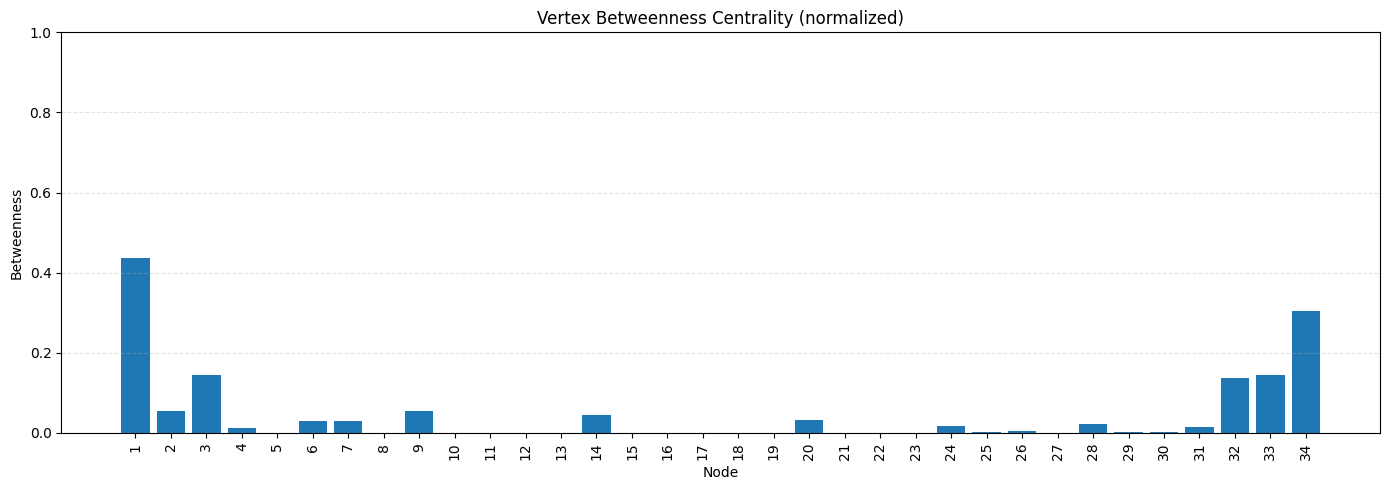

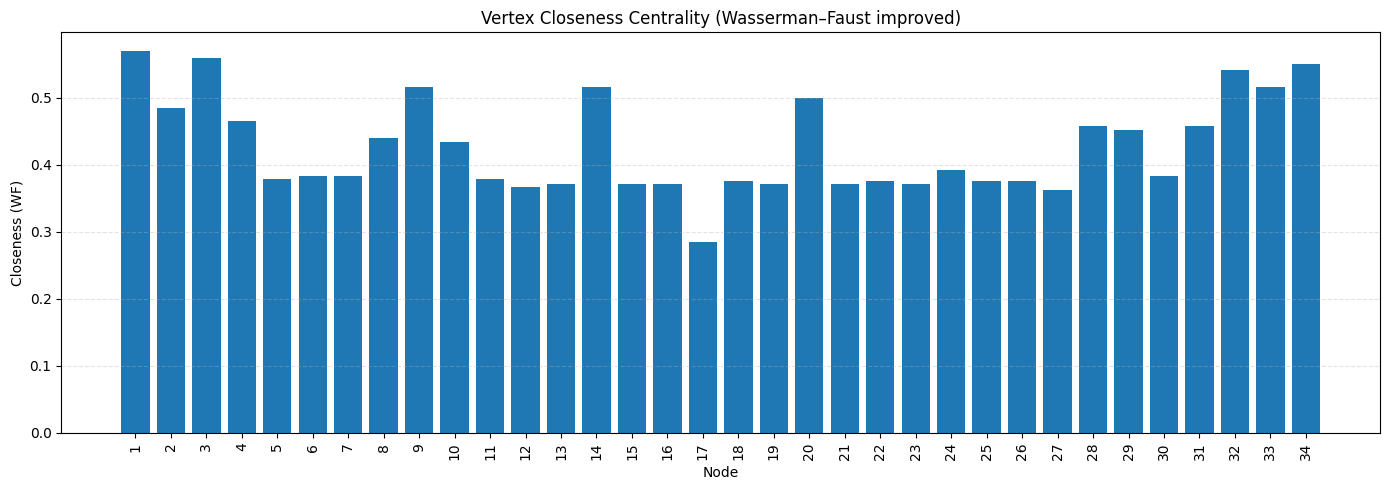

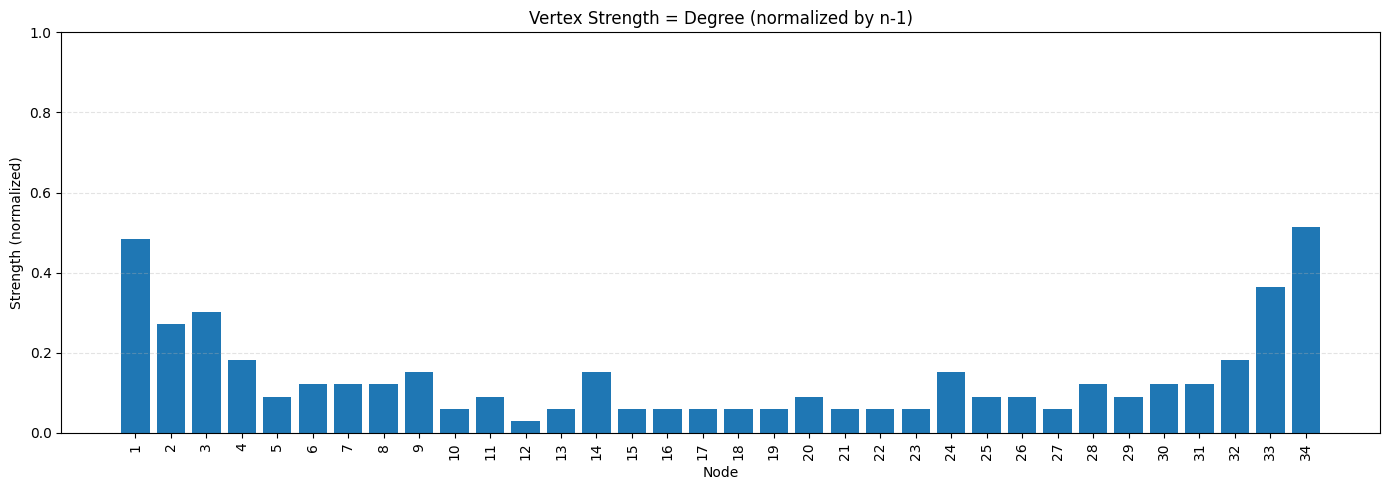

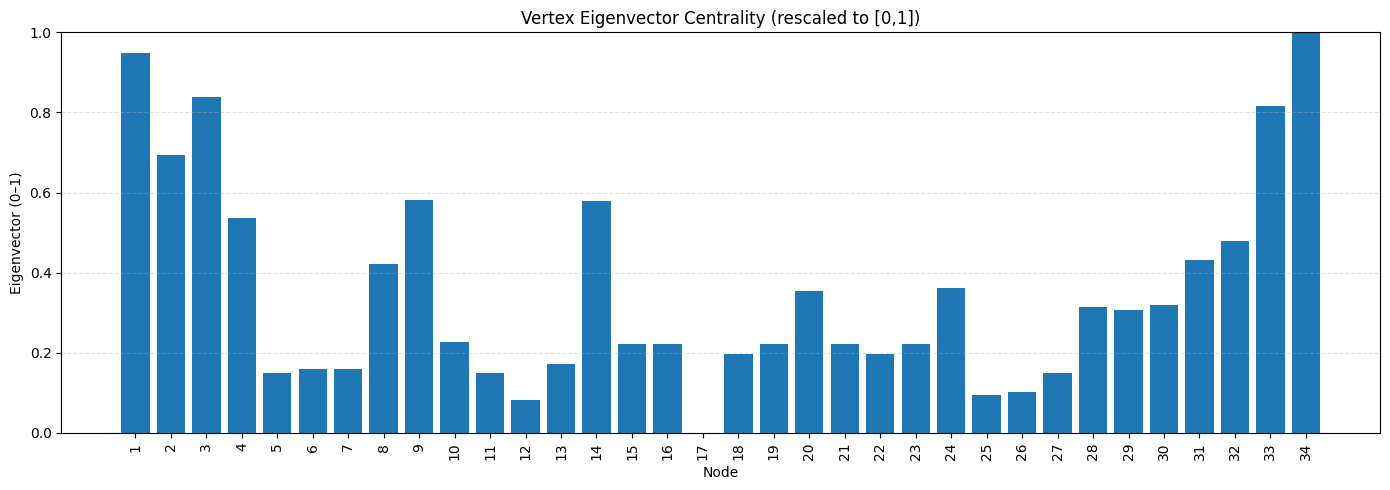

In [81]:
# =========================
# Q1a — Bar charts per vertex centrality
# =========================

def plot_metric_by_node(values_dict, title, ylabel="Value", sort=True, ylim=None, figsize=(14,5)):
    """
    Bar chart helper.
    - values_dict: {node: value}
    - sort=True: sort nodes by value (desc) for easier visual comparison.
                 Set sort=False to keep nodes in numeric order.
    - ylim=(ymin, ymax): e.g., (0,1) for normalized metrics.
    """
    if sort:
        nodes = [k for k,_ in sorted(values_dict.items(), key=lambda kv: (-kv[1], kv[0]))]
    else:
        nodes = sorted(values_dict.keys())
    vals = [values_dict[u] for u in nodes]

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(range(len(nodes)), vals)
    ax.set_xticks(range(len(nodes)))
    ax.set_xticklabels(nodes, rotation=90)
    ax.set_xlabel("Node")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    if ylim is not None:
        ax.set_ylim(*ylim)
    fig.tight_layout()
    plt.show()

# ---- Build one combined table for all vertex metrics (handy for export) ----
vertex_cent_df = pd.DataFrame({"node": sorted(G.nodes())})

vertex_cent_df = vertex_cent_df.merge(
    pd.DataFrame({"node": list(node_bet.keys()),
                  "betweenness": list(node_bet.values())}),
    on="node", how="left"
)

vertex_cent_df = vertex_cent_df.merge(
    pd.DataFrame({"node": list(node_clo.keys()),
                  "closeness_wf": list(node_clo.values())}),
    on="node", how="left"
)

vertex_cent_df = vertex_cent_df.merge(
    pd.DataFrame({"node": list(v_strength_raw.keys()),
                  "degree": list(v_strength_raw.values()),
                  "strength_norm": [v_strength_01[u] for u in v_strength_raw]}),
    on="node", how="left"
)

vertex_cent_df = vertex_cent_df.merge(
    pd.DataFrame({"node": list(eig.keys()),
                  "eigenvector_01": [eig_01[u] for u in eig]}),
    on="node", how="left"
)

display(vertex_cent_df.sort_values("node").head(10))

# ---- Bar plots (set sort=False if you prefer node-id order on x-axis) ----

# Betweenness (already normalized by NetworkX to [0,1] for undirected)
# Betweenness (normalized)
plot_metric_by_node(
    node_bet,
    title="Vertex Betweenness Centrality (normalized)",
    ylabel="Betweenness",
    sort=False,  # <- keep node IDs in increasing order
    ylim=(0, 1)
)

# Closeness (WF improved)
plot_metric_by_node(
    node_clo,
    title="Vertex Closeness Centrality (Wasserman–Faust improved)",
    ylabel="Closeness (WF)",
    sort=False,  # <- keep node IDs in increasing order
    ylim=None
)

# Strength = degree normalized by (n-1)
plot_metric_by_node(
    v_strength_01,
    title="Vertex Strength = Degree (normalized by n-1)",
    ylabel="Strength (normalized)",
    sort=False,  # <- keep node IDs in increasing order
    ylim=(0, 1)
)

# Eigenvector centrality rescaled to [0,1]
plot_metric_by_node(
    eig_01,
    title="Vertex Eigenvector Centrality (rescaled to [0,1])",
    ylabel="Eigenvector (0–1)",
    sort=False,  # <- keep node IDs in increasing order
    ylim=(0, 1)
)

# (Optional) Save the combined table
# vertex_cent_df.to_csv("karate_vertex_centralities_all.csv", index=False)



# Overall Finding

Nodes **1** and **34** are the most influential actors in the network. Node 1 functions primarily as the **bridge** across groups, while node 34 is the main **hub**. Network connectivity and information flow rely heavily on these vertices, consistent with the dataset’s description.

---

## 1) Different Ways of Being Important (Q1a)

* **Node 1 (Mr. Hi):** Highest **betweenness** and **closeness**. It intermediates many interactions and can reach others quickly.
* **Node 34 (John A.):** Highest **degree (strength)** and **eigenvector** centrality. It is the dominant hub and is well connected to other influential members.
* In short: **betweenness** is led by node 1, while **degree** and **eigenvector** are concentrated among a small set (notably nodes 1, 34, 3, 33).

---

## Key Vertex Analysis

* **Node 1 (Broker role):** Exhibits the **largest betweenness** by a wide margin, indicating it lies on many shortest paths. Removing it would likely fragment the network or increase distances substantially.
* **Node 34 (Hub role):** Has the **highest strength (17)** and **top eigenvector centrality (0.373)**, reflecting many direct ties and strong connections to other important nodes. It also shows the **second-highest betweenness**, reinforcing its strategic position.
* **Nodes 33, 32, 3 (Secondary hubs):** Consistently rank near the top across multiple measures, serving as secondary connectors and distributors of information.

---

## Interpretation of Centrality Measures

### Vertex Centrality

* **Strength (Degree):** The distribution is highly skewed. Most nodes have few ties, while **nodes 34 (17)** and **1 (16)** are clear hubs, suggesting a centralized structure.
* **Closeness:** The fastest to reach others are **1, 3, 34, and 32**, positioning them well for efficient information spread. Nodes with low closeness (e.g., **17**) sit on the periphery.
* **Betweenness:** Extremely skewed. **Node 1** dominates, controlling many cross-group paths. This indicates a vulnerability: the network’s cohesion depends strongly on a single broker.
* **Eigenvector:** Confirms hub influence. **Nodes 34 and 1** rank highest, meaning they are not only well connected, but connected to other well-connected nodes.

### Edge Centrality

* **Edge Strength:** The graph is unweighted; all edges have strength **1.0**.
* **Edge Betweenness:** Highlights key bridges. The edge **(1, 32)** has the highest score **(0.255)**, making it a critical conduit between parts of the network.

---

## Correlation of Centrality Measures

* **Strength, betweenness, and eigenvector** centralities are **highly correlated** (all **> 0.91**). Nodes with many connections tend also to be critical bridges and influential by position.
* **Closeness** shows a **somewhat weaker correlation** with the others (about **0.72–0.90**). Being well placed for short paths does not always coincide with being the largest hub or the main broker.


# Q1b


In [82]:
# --- Helpers to get roomier layouts ---

def _layout_spread(G, layout="spring", spread=2.5, seed=17, scale=3.0):
    """
    Roomier 2D layout.
    - For spring: k ~ spread/sqrt(n) increases ideal pairwise distances.
    - For kamada_kawai: uses built-in stress-minimization (already fairly roomy).
    """
    n = max(G.number_of_nodes(), 1)
    if layout == "spring":
        k = spread / np.sqrt(n)
        return nx.spring_layout(G, seed=seed, k=k, iterations=500, scale=scale)
    elif layout == "kamada_kawai":
        return nx.kamada_kawai_layout(G, scale=scale)
    else:  # fallback
        return nx.spring_layout(G, seed=seed, iterations=500, scale=scale)

def _component_layout(H, comps, layout="spring", spread=2.5, gap=6.0, scale=3.0, seed=17):
    """
    Compute a combined position dict that lays out each component separately, then
    shifts them apart along the x-axis by 'gap'.
    """
    pos_all = {}
    # place components left-to-right
    x_offset = 0.0
    for idx, S in enumerate(comps, start=1):
        sub = H.subgraph(S).copy()
        pos_sub = _layout_spread(sub, layout=layout, spread=spread, seed=seed+idx, scale=scale)
        # center each sublayout near the origin, then offset on x
        xs = np.array([p[0] for p in pos_sub.values()])
        ys = np.array([p[1] for p in pos_sub.values()])
        cx, cy = xs.mean(), ys.mean()
        for u, (x, y) in pos_sub.items():
            pos_all[u] = (x - cx + x_offset, y - cy)
        x_offset += gap  # push the next component to the right
    return pos_all


def centrality_callable(metric_name):
    """Return a function(G)-> dict(node->score) for the given metric name."""
    if metric_name == "betweenness":
        return lambda H: nx.betweenness_centrality(H, normalized=True)
    elif metric_name == "closeness":
        return lambda H: nx.closeness_centrality(H, wf_improved=True)
    elif metric_name == "strength":
        # normalized degree
        return lambda H: {u: (deg/(H.number_of_nodes()-1) if H.number_of_nodes()>1 else 0.0)
                          for u, deg in H.degree()}
    elif metric_name == "eigenvector":
        # rescale to [0,1] for fair comparison
        def _eig(H):
            # If H is disconnected, eigenvector_centrality still runs on the whole H,
            # but influence can concentrate on one component. That's fine for removal;
            # after fragmentation, we analyze per-component separately.
            x = nx.eigenvector_centrality(H, max_iter=2000)
            return normalize_to_01(x)
        return _eig
    else:
        raise ValueError("Unknown metric name.")

def fragment_by_removing(G, metric_name, verbose=True):
    """Adaptively remove highest-centrality nodes until exactly two connected components remain.
       Returns: remaining_graph, removed_nodes (in order), components (list of sets)"""
    H = G.copy()
    removed = []
    compute_c = centrality_callable(metric_name)

    while True:
        comps = list(nx.connected_components(H))
        if len(comps) == 2:
            if verbose:
                print(f"Reached 2 components after removing {len(removed)} nodes.")
            break
        if len(comps) > 2:
            if verbose:
                print(f"Already more than 2 components ({len(comps)}). Stopping.")
            break

        # Compute centrality on current H
        cdict = compute_c(H)
        # pick highest; tie-break by node id for determinism
        top = sorted(cdict.items(), key=lambda kv: (-kv[1], kv[0]))[0][0]
        removed.append(top)
        H.remove_node(top)

        if verbose:
            print(f"Removed node {top}; components now: {nx.number_connected_components(H)}")

        if H.number_of_nodes() == 0:
            if verbose:
                print("Graph exhausted before reaching 2 components.")
            break

    comps = list(nx.connected_components(H))
    comps = sorted(comps, key=lambda s: -len(s))  # biggest first
    return H, removed, comps

# --- Drop-in replacement for your analyze_components() ---

def analyze_components(H, comps, title_prefix="", layout="spring", spread=2.5, gap=8.0):
    """Compute centralities within each component and plot with extra spacing."""
    for i, S in enumerate(comps, start=1):
        sub = H.subgraph(S).copy()
        print(f"\n{title_prefix} Component {i}: |V|={sub.number_of_nodes()}, |E|={sub.number_of_edges()}")
        # Recompute centralities within this component (proper normalization within-subgraph)
        bet = nx.betweenness_centrality(sub, normalized=True)
        clo = nx.closeness_centrality(sub, wf_improved=True)
        st_raw, st01 = degree_strength(sub)
        eig = nx.eigenvector_centrality(sub, max_iter=2000)
        # Rank (top-5) preview
        def topk(d, k=5): return [int(x) for x,_ in sorted(d.items(), key=lambda kv: -kv[1])[:k]]
        print("  Top-5 betweenness:", topk(bet))
        print("  Top-5 closeness  :", topk(clo))
        print("  Top-5 strength   :", topk(st01))
        print("  Top-5 eigenvector:", topk(eig))

    # --- clearer, larger plot with roomy spacing ---
    pos = _component_layout(H, comps, layout=layout, spread=spread, gap=gap, scale=3.0, seed=17)

    plt.figure(figsize=(14, 10))  # bigger canvas
    nx.draw_networkx_edges(H, pos, width=1.6, alpha=0.55, edge_color="#444444")
    nx.draw_networkx_nodes(
        H, pos,
        node_size=900,           # bigger nodes
        node_color="#CFE8FF",
        edgecolors="#222222",
        linewidths=1.0
    )
    # readable labels with light box
    nx.draw_networkx_labels(
        H, pos,
        font_size=11,
        font_weight="semibold",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
    )
    plt.title(f"{title_prefix} Remaining graph split into {len(comps)} components\n"
              f"(layout='{layout}', spread={spread}, gap={gap})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()




Fragmentation by removing highest-betweenness nodes (adaptive):
Removed node 1; components now: 3
Already more than 2 components (3). Stopping.
Removed nodes (in order): [1]
Component sizes: [27, 5, 1]

[betweenness] Component 1: |V|=27, |E|=56
  Top-5 betweenness: [34, 3, 33, 2, 4]
  Top-5 closeness  : [34, 33, 3, 14, 28]
  Top-5 strength   : [34, 33, 3, 2, 4]
  Top-5 eigenvector: [34, 33, 3, 9, 24]

[betweenness] Component 2: |V|=5, |E|=6
  Top-5 betweenness: [6, 7, 5, 11, 17]
  Top-5 closeness  : [6, 7, 5, 11, 17]
  Top-5 strength   : [6, 7, 5, 11, 17]
  Top-5 eigenvector: [6, 7, 17, 5, 11]

[betweenness] Component 3: |V|=1, |E|=0
  Top-5 betweenness: [12]
  Top-5 closeness  : [12]
  Top-5 strength   : [12]
  Top-5 eigenvector: [12]


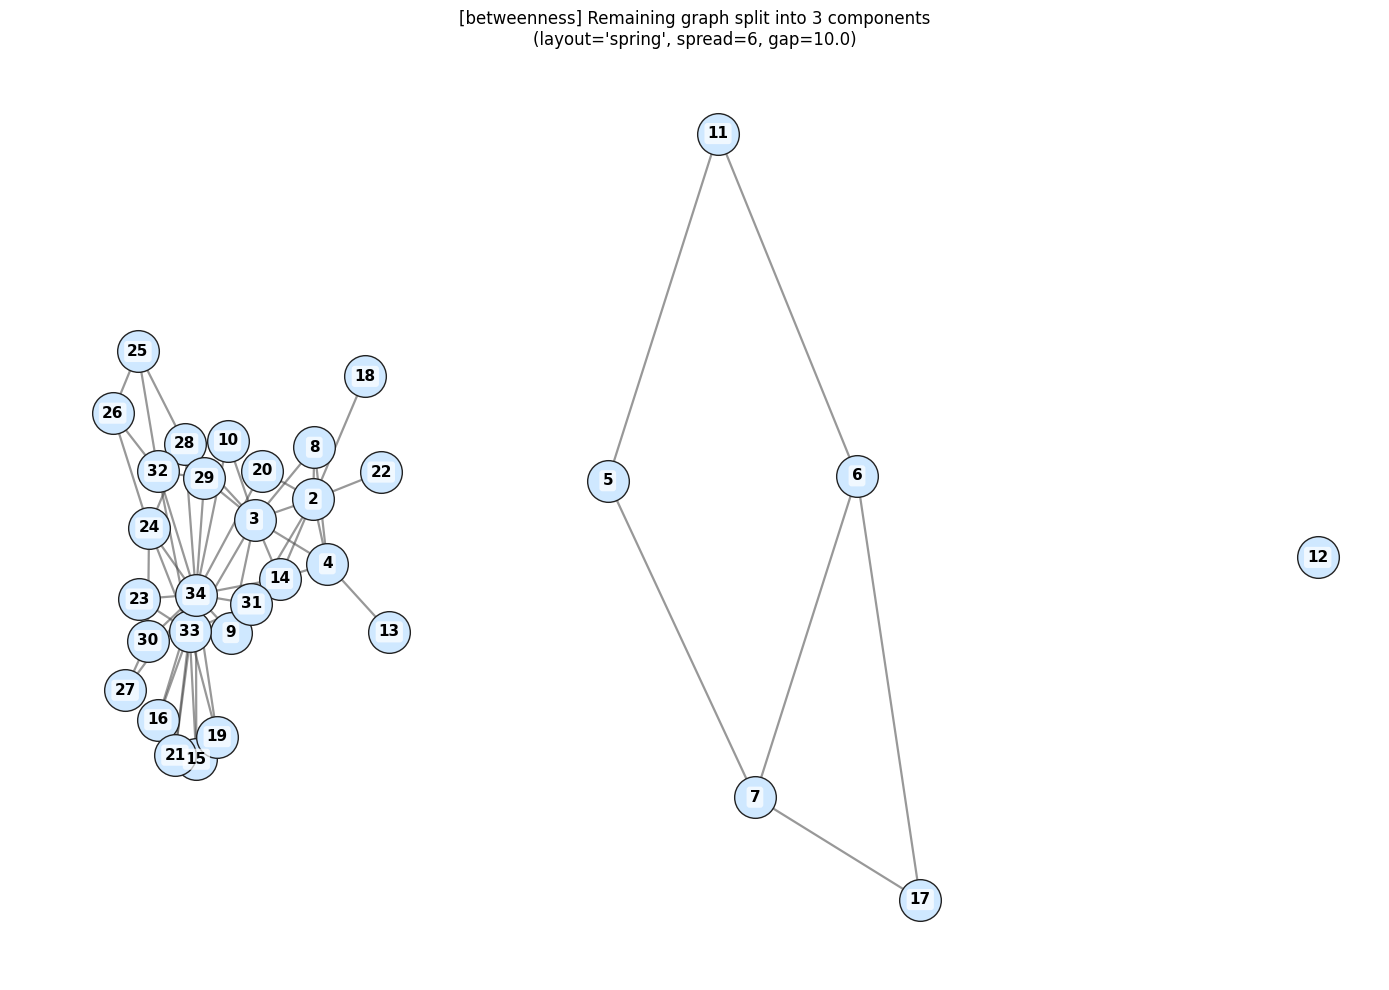


Fragmentation by removing highest-closeness nodes (adaptive):
Removed node 1; components now: 3
Already more than 2 components (3). Stopping.
Removed nodes (in order): [1]
Component sizes: [27, 5, 1]

[closeness] Component 1: |V|=27, |E|=56
  Top-5 betweenness: [34, 3, 33, 2, 4]
  Top-5 closeness  : [34, 33, 3, 14, 28]
  Top-5 strength   : [34, 33, 3, 2, 4]
  Top-5 eigenvector: [34, 33, 3, 9, 24]

[closeness] Component 2: |V|=5, |E|=6
  Top-5 betweenness: [6, 7, 5, 11, 17]
  Top-5 closeness  : [6, 7, 5, 11, 17]
  Top-5 strength   : [6, 7, 5, 11, 17]
  Top-5 eigenvector: [6, 7, 17, 5, 11]

[closeness] Component 3: |V|=1, |E|=0
  Top-5 betweenness: [12]
  Top-5 closeness  : [12]
  Top-5 strength   : [12]
  Top-5 eigenvector: [12]


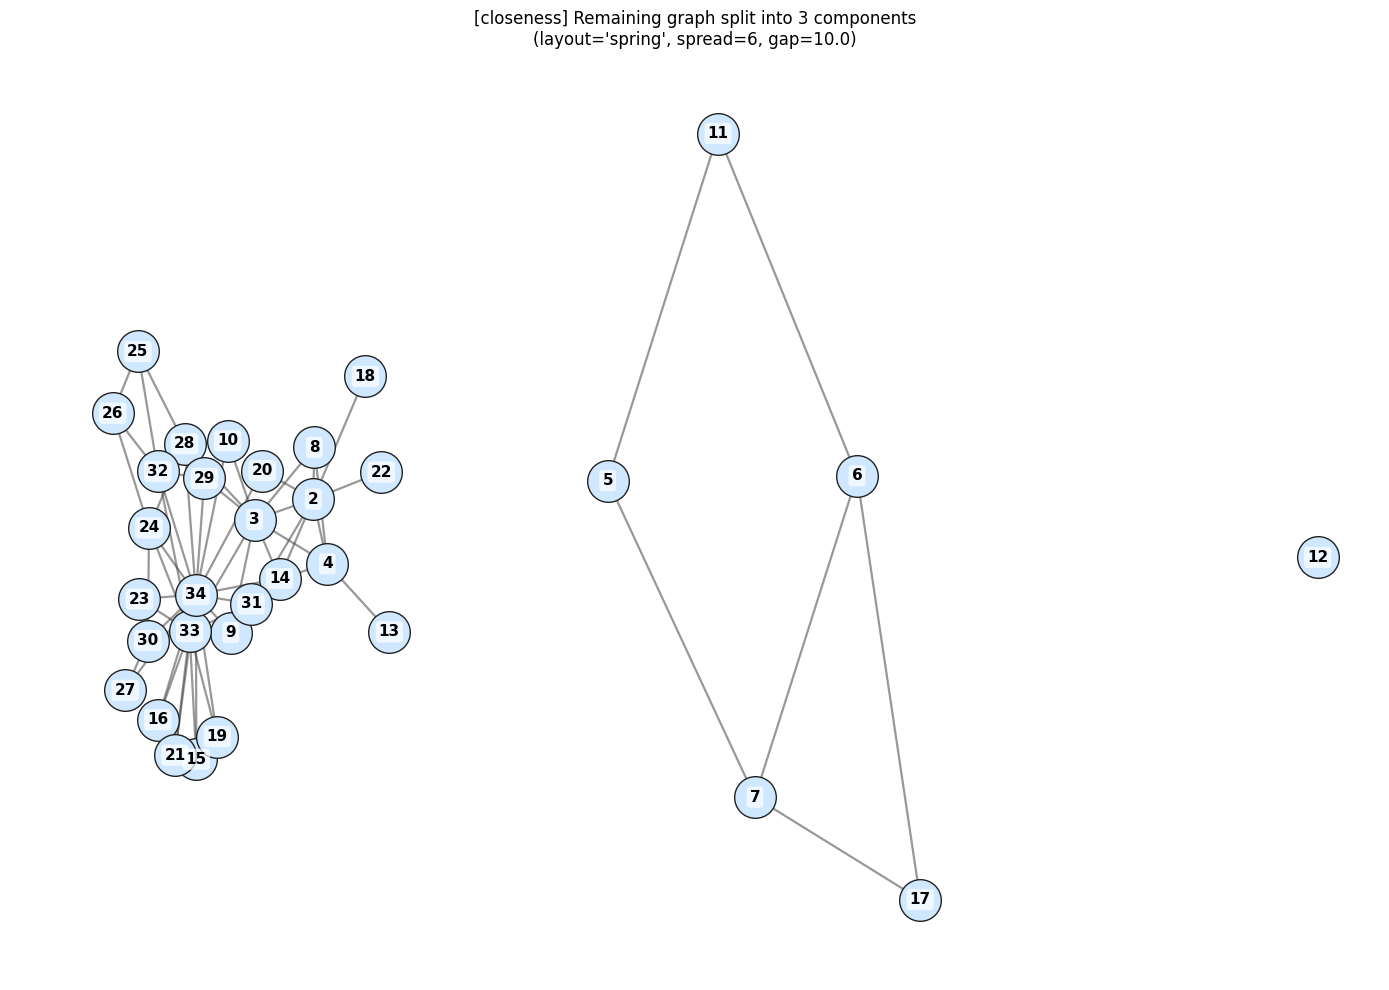


Fragmentation by removing highest-strength nodes (adaptive):
Removed node 34; components now: 1
Removed node 1; components now: 3
Already more than 2 components (3). Stopping.
Removed nodes (in order): [34, 1]
Component sizes: [26, 5, 1]

[strength] Component 1: |V|=26, |E|=39
  Top-5 betweenness: [33, 3, 2, 4, 30]
  Top-5 closeness  : [3, 33, 9, 31, 2]
  Top-5 strength   : [33, 3, 2, 4, 24]
  Top-5 eigenvector: [3, 33, 2, 4, 8]

[strength] Component 2: |V|=5, |E|=6
  Top-5 betweenness: [6, 7, 5, 11, 17]
  Top-5 closeness  : [6, 7, 5, 11, 17]
  Top-5 strength   : [6, 7, 5, 11, 17]
  Top-5 eigenvector: [6, 7, 17, 5, 11]

[strength] Component 3: |V|=1, |E|=0
  Top-5 betweenness: [12]
  Top-5 closeness  : [12]
  Top-5 strength   : [12]
  Top-5 eigenvector: [12]


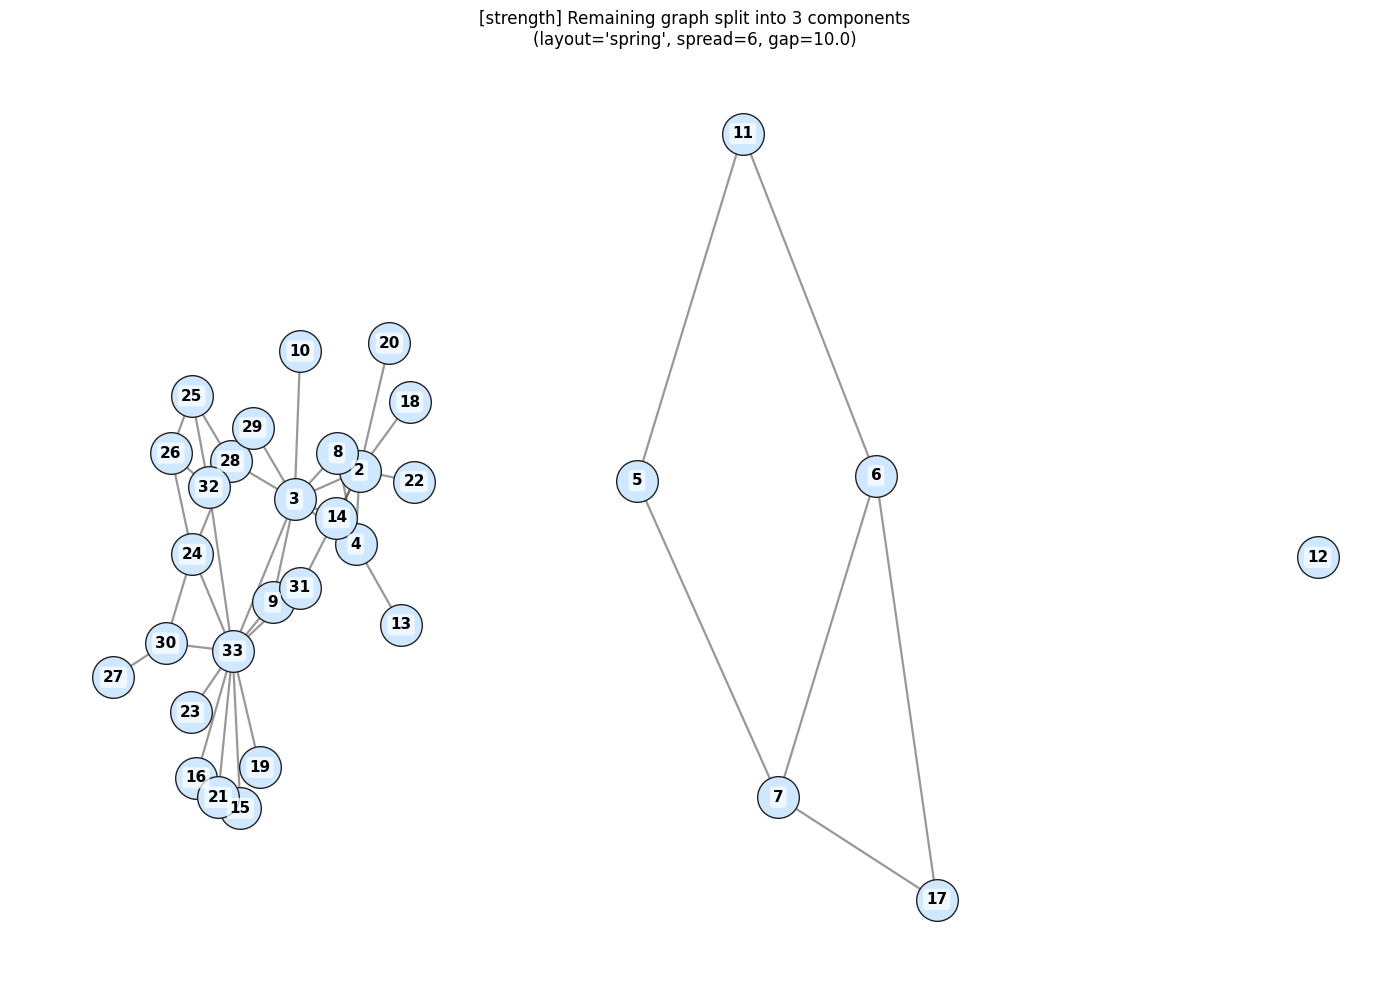


Fragmentation by removing highest-eigenvector nodes (adaptive):
Removed node 34; components now: 1
Removed node 1; components now: 3
Already more than 2 components (3). Stopping.
Removed nodes (in order): [34, 1]
Component sizes: [26, 5, 1]

[eigenvector] Component 1: |V|=26, |E|=39
  Top-5 betweenness: [33, 3, 2, 4, 30]
  Top-5 closeness  : [3, 33, 9, 31, 2]
  Top-5 strength   : [33, 3, 2, 4, 24]
  Top-5 eigenvector: [3, 33, 2, 4, 8]

[eigenvector] Component 2: |V|=5, |E|=6
  Top-5 betweenness: [6, 7, 5, 11, 17]
  Top-5 closeness  : [6, 7, 5, 11, 17]
  Top-5 strength   : [6, 7, 5, 11, 17]
  Top-5 eigenvector: [6, 7, 17, 5, 11]

[eigenvector] Component 3: |V|=1, |E|=0
  Top-5 betweenness: [12]
  Top-5 closeness  : [12]
  Top-5 strength   : [12]
  Top-5 eigenvector: [12]


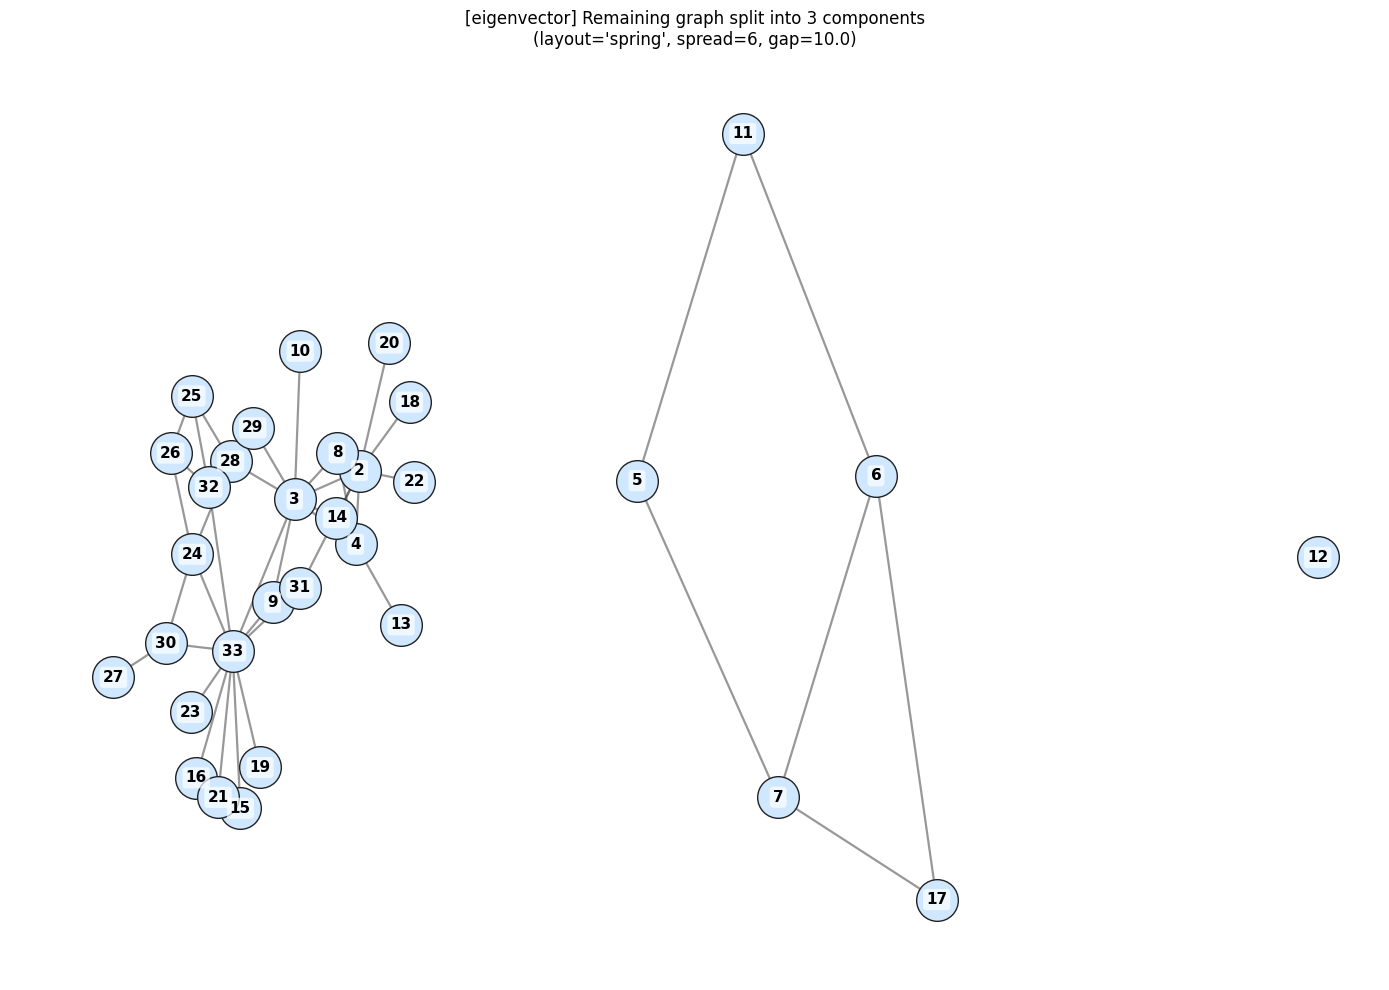

In [83]:
for metric in ["betweenness", "closeness", "strength", "eigenvector"]:
    print("\n"+"="*70)
    print(f"Fragmentation by removing highest-{metric} nodes (adaptive):")
    H_final, removed_nodes, comps = fragment_by_removing(G, metric, verbose=True)
    print(f"Removed nodes (in order): {removed_nodes}")
    print("Component sizes:", [len(c) for c in comps])
    analyze_components(H_final, comps, title_prefix=f"[{metric}]", layout="spring", spread=6, gap=10.0)


# Interpretation (Network Fragmentation)

**Overview.**
Iterative removal of top-centrality vertices shows a consistent picture: the network has a hub-and-bridge structure anchored by **Node 1** and **Node 34**. **Node 1** is the critical bridge; **Node 34** is the principal hub.

---

## Fragmentation outcomes across centralities

* **Betweenness / Closeness:** Removing **Node 1** alone immediately splits the graph into **three components** with sizes **\[27, 5, 1]**. The split into exactly two components is skipped, which underscores Node 1’s role as the unique conduit between regions.
* **Eigenvector / Strength (degree):** The graph remains connected after removing a single leader; fragmentation appears only after removing **two** high-centrality nodes—**Node 34** followed by **Node 1**—yielding **\[26, 5, 1]**. This indicates higher robustness against removing a single “influencer” but vulnerability when both leaders are targeted.

**Efficiency summary.**

* **Most efficient:** Betweenness & Closeness (remove **1** node; ≈**97.1%** of nodes preserved).
* **Moderately efficient:** Strength & Eigenvector (remove **2** nodes; ≈**94.1%** preserved).

---

## Structural reading

* The graph exhibits a **hub-and-bridge architecture**:

  * A dense **main core** (\~26–27 nodes),
  * A **five-node cluster** whose connectivity depends on **Node 1**,
  * A **peripheral singleton** (e.g., Vertex 12) that is easily isolated.
* **Node 1** acts as a **single chokepoint**; there are **no alternative routes** between major regions once it is removed.
* **Node 34** contributes high connectivity and influence but, by itself, is **less decisive** for global cohesion than Node 1.

---

## Implications

* The network has **low fault tolerance** and is **highly susceptible** to targeted removal of the bridge (Node 1).
* **Redundancy is lacking**: minimal targeted attacks can partition the graph into multiple components.
* These observations align with the known sociological split into factions led by **Node 1 (instructor)** and **Node 34 (administrator)**.

---

## Recommendations

* **Add redundant cross-links** between the main core and the five-node cluster to reduce dependence on **Node 1**.
* **Introduce alternative inter-community paths** (e.g., cross-edges connecting neighbors of Nodes 1 and 34) to prevent a single point of failure and improve resilience to both targeted and random failures.
